In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

import ujson, os

from scipy.stats import scoreatpercentile as scap

from cmdstanpy import set_cmdstan_path, CmdStanModel, from_csv
import arviz as az
import corner

from astropy.table import Table
import astropy.units as u
import astropy.constants as c
from astropy.coordinates import Galactocentric, ICRS, CartesianDifferential
au_km_year_per_sec = (c.au / (1*u.yr).to(u.s)).to(u.km/u.s).value

from plotstyles import useagab, apply_tufte
from robuststats import rse

from diskkinematicmodel import *
from icrstogal import *
from loadmwsamples import *

useagab()

In [2]:
Rsun = 8277.0*u.pc

fgkmtable = load_mwtable('./data/FGKMGoldenSample.fits', Rsun=Rsun, esphs=False)

Number of stars in selected sample: 23789


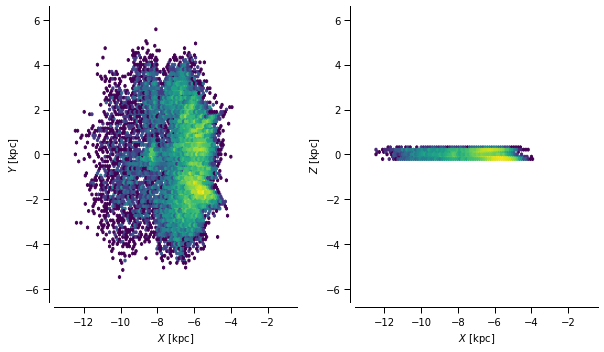

In [3]:
plx_snrlim = 10
vtanhalo = 180.0

plxfilter = fgkmtable['parallax_over_error']>plx_snrlim
zmax = 250

sample_filter_init = plxfilter & (np.abs(np.sin(np.deg2rad(fgkmtable['b']))*1000/fgkmtable['parallax']) < zmax)

R_filter = (fgkmtable['R_gc']>6500.0) & (fgkmtable['R_gc']<15000.0)

no_spt_filter = fgkmtable['source_id'] > 0
giants = fgkmtable['logg_gspphot'] <= 3.0
fstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] > 6000)
gstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 6000) & (fgkmtable['teff_gspphot'] > 5000)
kstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 5000) & (fgkmtable['teff_gspphot'] > 4000)
mstars = (fgkmtable['logg_gspphot'] > 4.0 ) & (fgkmtable['teff_gspphot'] <= 4000)

# Choice of stars
spt_lum_filter = giants
fit_save_location = os.path.join(os.getcwd(), 'fitfiles/giants')

sample_filter = sample_filter_init & spt_lum_filter #& R_filter

print(f"Number of stars in selected sample: {fgkmtable['ra'][sample_filter].size}")

subsample_size = 3000
if (fgkmtable['ra'][sample_filter].size <=subsample_size):
    fgkm_subsample = fgkmtable[sample_filter]
else:
    random_subsample = np.random.choice(np.arange(fgkmtable['ra'][sample_filter].size), size=subsample_size, replace=False)
    fgkm_subsample = fgkmtable[sample_filter][random_subsample]
    
plotgrid = [-13, -1, -6, 6]
fig=plt.figure(figsize=(8.5,5), tight_layout=True)

gs = fig.add_gridspec(1, 2, figure=fig)

ax_xy = fig.add_subplot(gs[0,0])
apply_tufte(ax_xy)
ax_xz = fig.add_subplot(gs[0,1])
apply_tufte(ax_xz)

ax_xy.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['y_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xy.set_xlabel(r'$X$ [kpc]') 
ax_xy.set_ylabel(r'$Y$ [kpc]') 

ax_xz.hexbin(fgkmtable['x_gc'][sample_filter]/1000, fgkmtable['z_gc'][sample_filter]/1000, mincnt=1, bins='log', extent=plotgrid)
ax_xz.set_xlabel(r'$X$ [kpc]') 
ax_xz.set_ylabel(r'$Z$ [kpc]')

plt.show()

Median d*sin(b): -74.5
RSE d*sin(b): 160.5
Mean d*sin(b): -33.7


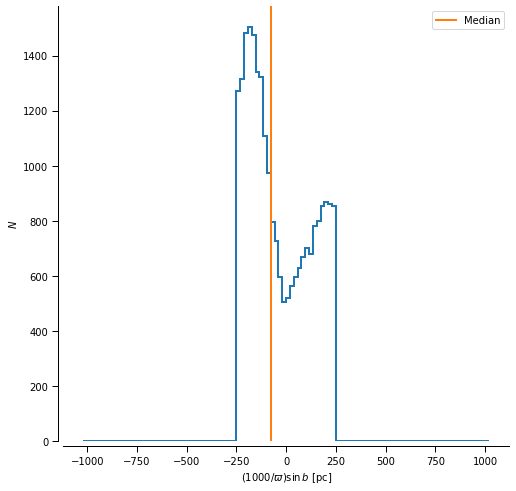

In [4]:
fig, axdsinb = plt.subplots(1, 1, figsize=(8,8))
apply_tufte(axdsinb)

dsinb = (np.sin(np.deg2rad(fgkmtable['b']))*1000.0/fgkmtable['parallax'])[sample_filter]
print(f"Median d*sin(b): {np.median(dsinb):.1f}")
print(f"RSE d*sin(b): {rse(dsinb):.1f}")
print(f"Mean d*sin(b): {dsinb.mean():.1f}")
zsun = 0.0*u.pc #-np.median(dsinb)*u.pc

axdsinb.hist(dsinb, bins='auto', histtype='step', lw=2, range=[-1020,1020])
axdsinb.axvline(x=np.median(dsinb), color='C1', label='Median')
axdsinb.set_xlabel(r'$(1000/\varpi)\sin b$ [pc]')
axdsinb.set_ylabel(r'$N$')
axdsinb.legend()

plt.show()

In [5]:
nsources = fgkm_subsample['ra'].size
print(f"Number of sources in sample: {nsources}")

fgkm_data = {'N': nsources, 
            'galon': np.deg2rad(fgkm_subsample['l']).tolist(), 
            'galat': np.deg2rad(fgkm_subsample['b']).tolist(),
            'pml_obs': fgkm_subsample['pml'].tolist(),
            'pml_obs_unc': fgkm_subsample['pml_error'].tolist(),
            'pmb_obs': fgkm_subsample['pmb'].tolist(),
            'pmb_obs_unc': fgkm_subsample['pmb_error'].tolist(),
            'pml_pmb_corr': fgkm_subsample['pml_pmb_corr'].tolist(),
            'plx_obs': fgkm_subsample['parallax'].tolist(),
            'Rsun': Rsun.value,
            'Zsun': zsun.value
            }
with open('fgkm.data.json', 'w') as fp: 
    ujson.dump(fgkm_data, fp)    # R: Converts python object to JSON data format
    fp.close()
    

base_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_1.stan',
                'npars': 7,
                'parnames':['h_param', 'p_param', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

improved_bp_model = {'stanfile':'stanfiles/rotcurve-bp2_2.stan',
                'npars': 8,
                'parnames':['h_param', 'p_param', 'v0', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz'],
                'labels':[r'h', r'p', 'V_0', r'$V_{X,\odot}(\mathrm{pec})$', r'$V_{Y,\odot}(\mathrm{pec})$', 
                         r'$V_{Z,\odot}(\mathrm{pec})$', r'$\sigma_{v,xy}$', r'$\sigma_{v,z}$'],
                'inits':{'h_param':3.0, 'p_param':-0.55, 'v0':234.0, 'Vsun_pec_x':11.1, 'Vsun_pec_y':12.24, 'Vsun_pec_z':7.25, 'vdispxy':10.0, 'vdispz':10.0},
                'best_params':{'h_param':np.nan, 'p_param':np.nan, 'v0':np.nan, 'Vsun_pec_x':np.nan, 'Vsun_pec_y':np.nan, 'Vsun_pec_z':np.nan, 'vdispxy':np.nan, 'vdispz':np.nan}
                }

stan_model = improved_bp_model

Number of sources in sample: 3000


In [6]:
# Reading in earlier produced fits
filter_dictionary = {
                  'no_spt_filter':no_spt_filter,
                  'giants':giants,
                  'fstars':fstars,
                  'gstars':gstars,
                  'kstars':kstars,
                  'mstars':mstars,
                 }
# Choice of stars
filter_of_choice = "giants"

spt_lum_filter = filter_dictionary[filter_of_choice]
fit_save_location = os.path.join(os.getcwd(), 'fitfiles', filter_of_choice)

fgkm_fit = from_csv(path=fit_save_location)
print(fit_save_location[-len(filter_of_choice):])

09:01:04 - cmdstanpy - WARNING - Some chains may have failed to converge.
	Chain 1 had 15 divergent transitions (1.5%)
	Chain 2 had 34 divergent transitions (3.4%)
	Chain 3 had 2 divergent transitions (0.2%)
	Chain 3 had 298 iterations at max treedepth (29.8%)
	Chain 4 had 1 divergent transitions (0.1%)
	Chain 4 had 3 iterations at max treedepth (0.3%)
	Use function "diagnose()" to see further information.


giants


In [7]:
print(fit_save_location)
fgkm_fit.summary()[0:stan_model['npars']+3]

C:\Users\rjrri\Documents\Universiteit\First project\milkyway-rotation-curve_fork\fitfiles\giants


,Mean,MCSE,StdDev,5%,50%,95%,N_Eff,N_Eff/s,R_hat
lp__,-8958.710000,413.139000,585.148000,-9546.460000,-8383.500000,-8371.360000,2.00604,0.000065,310.67300
h_param,0.098617,0.001444,0.099378,0.006030,0.066553,0.303207,4735.10000,0.153064,1.00001
p_param,-1.089510,0.867327,1.334430,-3.450330,-0.029906,0.168904,2.36715,0.000077,2.45604
v0,61.419300,119.996000,182.726000,-141.227000,-46.370500,355.266000,2.31883,0.000075,2.59331
Vsun_pec_x,17.534300,2.299950,3.450790,13.016500,16.777700,22.647500,2.25113,0.000073,2.87343
Vsun_pec_y,246.940000,130.923000,185.471000,59.928100,413.484000,440.100000,2.00689,0.000065,45.54750
Vsun_pec_z,9.256400,0.006403,0.386661,8.620160,9.256770,9.887590,3646.33000,0.117869,1.00131
vdispxy,45.521600,7.096840,10.064700,34.904300,53.031300,56.450000,2.01126,0.000065,18.40660
vdispz,20.771700,0.004833,0.269948,20.335400,20.775300,21.220100,3119.58000,0.100842,1.00154
"model_pm[1,1]",-3.224250,1.207140,1.711630,-5.044120,-1.844860,-1.390230,2.01050,0.000065,19.85890


In [54]:
import winsound
frequency = 1000  # Set Frequency To 2500 Hertz
duration = 2000  # Set Duration To 1000 ms == 1 second
winsound.Beep(frequency, duration)

In [31]:
# data Rsun
# real Vcirc_sun = Rsun/h_param * (1 + (Rsun/h_param)^2) ^ ((p_param-2)/4);
# This is only the scaling factor. What is v_0?
Rsun_float = float(Rsun/(1*u.pc)) # in pc
print(Rsun_float)
h_param = 0.14
p_param = 0.370 # in pc
# v_0 = 
vcsun_data = 234.0
Vcircsun = Rsun_float/h_param * (1 + (Rsun_float/h_param)**2) ** ((p_param-2)/4)
v0 = vcsun_data/Vcircsun
vc = v0*Vcircsun

print("Vcircsun:", Vcircsun*u.pc/(u.s))
Vcircsun_with_units = Vcircsun*u.pc/u.s
print("Vcircsun:", Vcircsun_with_units.to(u.km/u.s))
print(v0)
print(vc)

8277.0
Vcircsun: 7.6343630711626504 pc / s
Vcircsun: 235571829776521.75 km / s
30.65088702473299
234.0


In [8]:
fgkm_fit.diagnose()

"Processing csv files: C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_2-20230305202027_1.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_2-20230305202027_2.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_2-20230305202027_3.csv, C:\\Users\\rjrri\\Documents\\Universiteit\\First project\\milkyway-rotation-curve_fork\\fitfiles\\giants\\rotcurve-bp2_2-20230305202027_4.csv\n\nChecking sampler transitions treedepth.\n301 of 4000 (7.53%) transitions hit the maximum treedepth limit of 10, or 2^10 leapfrog steps.\nTrajectories that are prematurely terminated due to this limit will result in slow exploration.\nFor optimal performance, increase this limit.\n\nChecking sampler transitions for divergences.\n52 of 4000 (1.30%) transitions ended with a divergence.\nThese divergent 

['h_param', 'p_param', 'v0', 'Vsun_pec_x', 'Vsun_pec_y', 'Vsun_pec_z', 'vdispxy', 'vdispz']
h_param = 0.1+0.1-0.1
p_param = -1.8+0.6-1.0
v0 = 233.5+20.7-20.3
Vsun_pec_x = 8.6+0.8-0.8
Vsun_pec_y = 21.5+0.9-1.0
Vsun_pec_z = 7.9+0.6-0.6
vdispxy = 39.0+0.5-0.5
vdispz = 22.3+0.5-0.5


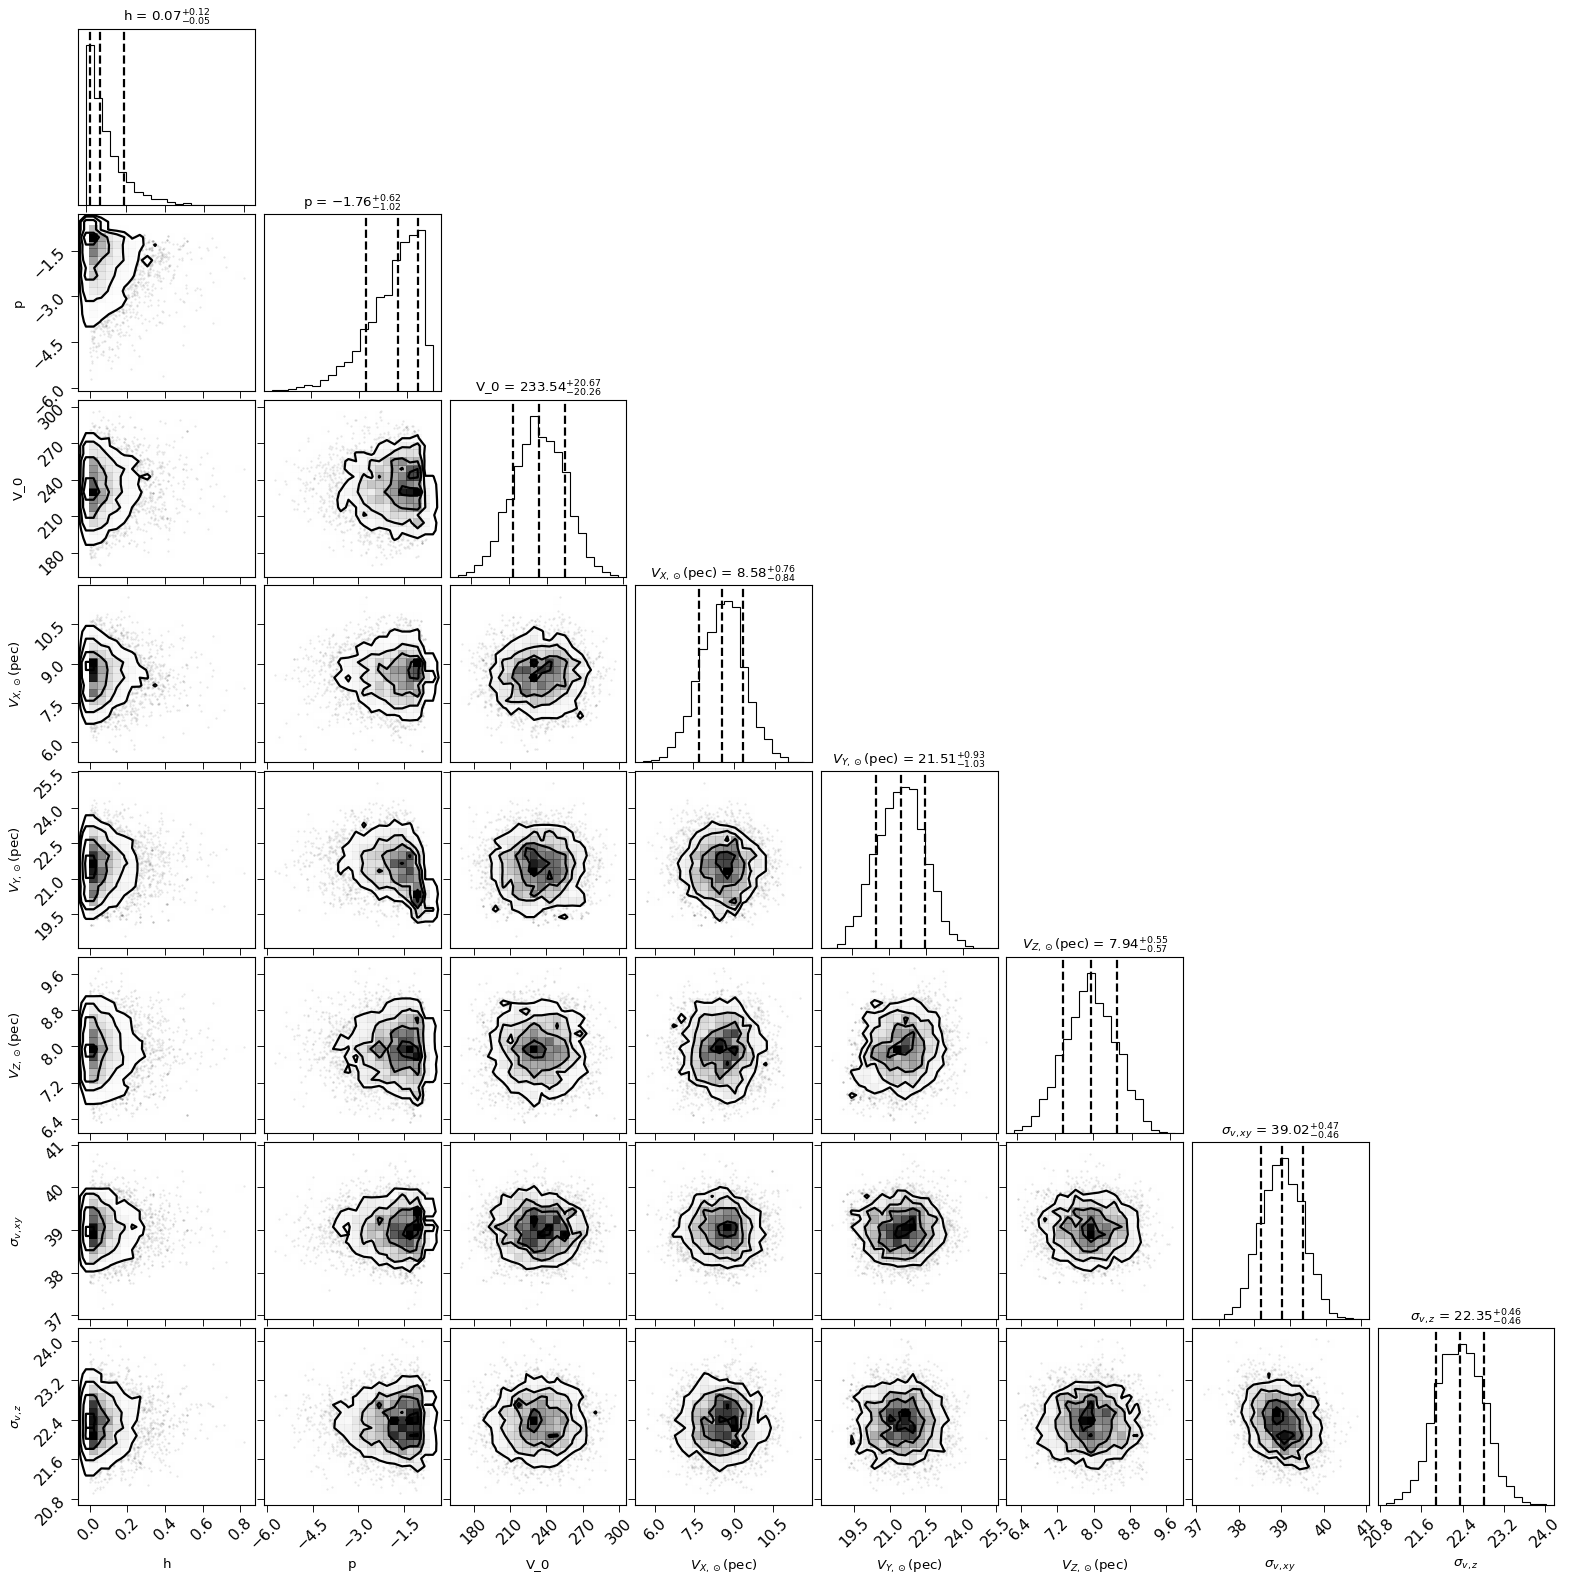

{'h_param': 0.0720605, 'p_param': -1.75894, 'v0': 233.5365, 'Vsun_pec_x': 8.57522, 'Vsun_pec_y': 21.505200000000002, 'Vsun_pec_z': 7.9389, 'vdispxy': 39.015, 'vdispz': 22.34835}
8
[array([0.066985 , 0.127786 , 0.0373771, ..., 0.0111614, 0.0200618,
       0.237918 ]), array([-1.94948, -3.3767 , -3.87774, ..., -1.94029, -2.9866 , -2.24772]), array([218.528, 262.622, 233.662, ..., 270.274, 251.16 , 244.16 ]), array([10.0802 ,  7.82747,  8.54187, ...,  6.89401,  8.35013,  8.41412]), array([21.7004, 20.3435, 20.9249, ..., 22.329 , 22.4206, 21.8164]), array([7.35582, 7.57967, 7.04731, ..., 7.51228, 7.98895, 8.45196]), array([38.5355, 39.78  , 39.2932, ..., 39.1842, 38.6499, 39.3889]), array([22.5121, 22.2424, 21.9067, ..., 22.4433, 22.1631, 21.6696])]
[[ 6.69850e-02 -1.94948e+00  2.18528e+02 ...  7.35582e+00  3.85355e+01
   2.25121e+01]
 [ 1.27786e-01 -3.37670e+00  2.62622e+02 ...  7.57967e+00  3.97800e+01
   2.22424e+01]
 [ 3.73771e-02 -3.87774e+00  2.33662e+02 ...  7.04731e+00  3.92932e+01

In [47]:
print(stan_model['parnames'])
for par in stan_model['parnames']:
    vals = fgkm_fit.stan_variable(par)
    stan_model['best_params'][par] = np.median(vals)
    q1, q2, q3 = scap(vals, [16, 50, 84])
    print(f"{par} = {q2:.1f}+{q3-q2:.1f}-{q2-q1:.1f}")

sample_lists = []
for i, par in zip(range(7, 7+stan_model['npars']), stan_model['parnames']): # Adjusted the number from 9 to 2 (# of parameters)
    sample_lists.append(fgkm_fit.draws()[:,:,i].flatten())
samples = np.vstack(sample_lists).transpose()

useagab(usetex=False, fontfam='sans-serif', fontsize=14, ncolors=10)

figcorner = plt.figure(figsize=(2.5*stan_model['npars'],2.5*stan_model['npars']))
corner.corner(
    samples, labels=stan_model['labels'], 
    label_kwargs={"fontsize":12}, title_kwargs={"fontsize": 12},
    truth_color='r', quantiles=[0.16,0.50,0.84], show_titles=True, fig=figcorner
)
plt.show()

# Number of draws is very low
print(stan_model['best_params'])
print(len(sample_lists))
print(sample_lists)
print(samples)
print(len(samples)) # 4000 samples
# Dit was gecreerd met een subsample van 10000 ipv 3000.